In [5]:
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.metrics import mean_squared_error
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [6]:
covid = pd.read_csv("WHO-COVID-19-global-data.csv")
fj_real = covid[(covid['Country_code'] == 'FJ') & (covid['Cumulative_cases'] >= 1)]
pf_real = covid[(covid['Country_code'] == 'PF') & (covid['Cumulative_cases'] >= 1)]
ws_real = covid[(covid['Country_code'] == 'WS') & (covid['Cumulative_cases'] >= 1)]

In [7]:
fj_sim = pd.read_csv("fj_no_measure.csv")
pf_sim = pd.read_csv("fp_no_measure.csv")
ws_sim = pd.read_csv("ws_no_measure.csv")

In [8]:
# Set display options to prevent line wrapping
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # No column width limit
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

In [6]:
fj_real = fj_real.fillna(0).astype({
    'New_cases': 'int64',
    'Cumulative_cases': 'int64',
    'New_deaths': 'int64',
    'Cumulative_deaths': 'int64'
})
print(fj_real.head())

      Date_reported Country_code Country WHO_region  New_cases  Cumulative_cases  New_deaths  Cumulative_deaths
16513    2020-03-22           FJ    Fiji       WPRO          2                 2           0                  0
16514    2020-03-29           FJ    Fiji       WPRO          3                 5           0                  0
16515    2020-04-05           FJ    Fiji       WPRO          7                12           0                  0
16516    2020-04-12           FJ    Fiji       WPRO          4                16           0                  0
16517    2020-04-19           FJ    Fiji       WPRO          1                17           0                  0


In [7]:
pf_real = pf_real.fillna(0).astype({
    'New_cases': 'int64',
    'Cumulative_cases': 'int64',
    'New_deaths': 'int64',
    'Cumulative_deaths': 'int64'
})
print(pf_real.head())

      Date_reported Country_code           Country WHO_region  New_cases  Cumulative_cases  New_deaths  Cumulative_deaths
17404    2020-03-15           PF  French Polynesia       WPRO          3                 3           0                  0
17405    2020-03-22           PF  French Polynesia       WPRO         15                18           0                  0
17406    2020-03-29           PF  French Polynesia       WPRO         17                35           0                  0
17407    2020-04-05           PF  French Polynesia       WPRO          5                40           0                  0
17408    2020-04-12           PF  French Polynesia       WPRO         11                51           0                  0


In [8]:
ws_real = ws_real.fillna(0).astype({
    'New_cases': 'int64',
    'Cumulative_cases': 'int64',
    'New_deaths': 'int64',
    'Cumulative_deaths': 'int64'
})
print(ws_real.head())

      Date_reported Country_code Country WHO_region  New_cases  Cumulative_cases  New_deaths  Cumulative_deaths
42195    2020-12-06           WS   Samoa       WPRO          1                 1           0                  0
42196    2020-12-13           WS   Samoa       WPRO          0                 1           0                  0
42197    2020-12-20           WS   Samoa       WPRO          0                 1           0                  0
42198    2020-12-27           WS   Samoa       WPRO          0                 1           0                  0
42199    2021-01-03           WS   Samoa       WPRO          0                 1           0                  0


/var/folders/6b/kz_zdjy5609583gv1q69hvcm0000gn/T/ipykernel_55111/681222953.py:10: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  combined_data['Date_reported'] = pd.to_datetime(combined_data['Date_reported'])


Country Date_reported  Fiji  French Polynesia  Samoa
0          2020-03-15     0                 3      0
1          2020-03-22     2                18      0
2          2020-03-29     5                35      0
3          2020-04-05    12                40      0
4          2020-04-12    16                51      0
['0 (0%)', '18 (0%)', '32 (0%)', '53 (0%)', '74 (0%)', '23139 (34%)']
['3 (0%)', '60 (0%)', '2026 (3%)', '17241 (22%)', '18696 (24%)', '19285 (24%)']
['0 (0%)', '0 (0%)', '0 (0%)', '1 (0%)', '1 (0%)', '1 (0%)']


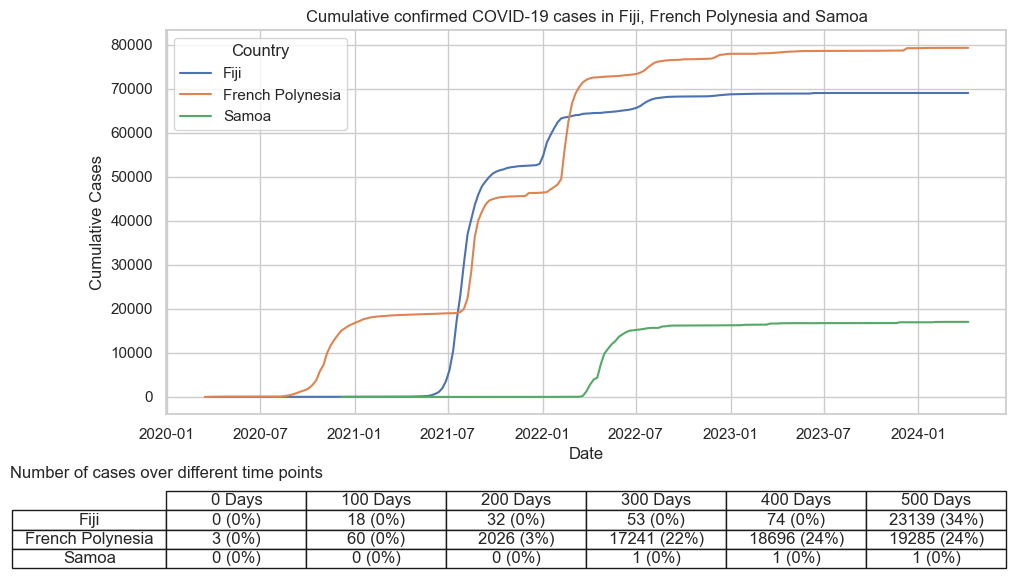

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设你的数据已经加载到 fj_real, pf_real 和 ws_real
# 合并数据集
combined_data = pd.concat([fj_real, pf_real, ws_real], ignore_index=True)

# 转换为长格式
combined_data['Date_reported'] = pd.to_datetime(combined_data['Date_reported'])
combined_data.sort_values('Date_reported', inplace=True)

# 获取每个国家在每个时间点上的累积病例数并将其转换为整数
risk_data = combined_data.pivot_table(values='Cumulative_cases', 
                                      index='Date_reported', 
                                      columns='Country', 
                                      aggfunc='max').fillna(0).reset_index()

# 将浮点数转换为整数
risk_data = risk_data.astype({country: 'int' for country in risk_data.columns if country != 'Date_reported'})

# 确保数据是正确的
print(risk_data.head())

# 将数据转换为适合绘制表格的格式
time_points = [0, 100, 200, 300, 400, 500]
countries = ['Fiji', 'French Polynesia', 'Samoa']

# 找到每个时间点的数据
risk_table = []
for country in countries:
    country_data = []
    for days in time_points:
        date = risk_data['Date_reported'].min() + pd.Timedelta(days=days, unit='D')
        nearest_date = risk_data['Date_reported'].loc[(risk_data['Date_reported'] - date).abs().idxmin()]
        cases = risk_data[risk_data['Date_reported'] == nearest_date][country].values[0]
        country_data.append(f"{cases} ({cases / risk_data[country].max() * 100:.0f}%)")
    risk_table.append(country_data)

# 设置列标签
columns = [f'{days} Days' for days in time_points]

# 打印生成的表格数据
for row in risk_table:
    print(row)

# 绘制累积曲线图
fig, ax = plt.subplots(figsize=(12, 8))

# 设置图表风格
sns.set(style="whitegrid")

# 绘制累积曲线图
sns.lineplot(data=combined_data, x='Date_reported', y='Cumulative_cases', hue='Country', hue_order=countries, errorbar=None, ax=ax)

# 添加图表标题和标签
ax.set_title('Cumulative confirmed COVID-19 cases in Fiji, French Polynesia and Samoa')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Cases')
ax.legend(title='Country')

# 添加“Number at risk”表格
table = plt.table(cellText=risk_table,
                  rowLabels=countries,
                  colLabels=columns,
                  cellLoc='center',
                  rowLoc='center',
                  loc='bottom',
                  bbox=[0, -0.4, 1, 0.2])

# 添加下标题
plt.figtext(0.2, 0.32, 'Number of cases over different time points', ha='center', fontsize=12)

plt.subplots_adjust(left=0.2, bottom=0.4)
plt.savefig('cumulative_cases.png', bbox_inches='tight', dpi=300)
plt.show()

/var/folders/6b/kz_zdjy5609583gv1q69hvcm0000gn/T/ipykernel_55111/2231972462.py:10: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  combined_data['Date_reported'] = pd.to_datetime(combined_data['Date_reported'])


Country Date_reported  Fiji  French Polynesia  Samoa
0          2020-03-15     0                 3      0
1          2020-03-22     2                18      0
2          2020-03-29     5                35      0
3          2020-04-05    12                40      0
4          2020-04-12    16                51      0
['18 (0%)', '49 (0%)', '6161 (9%)', '54834 (79%)', '65713 (95%)', '68750 (100%)']
['62 (0%)', '16926 (21%)', '19011 (24%)', '46425 (59%)', '73386 (93%)', '77957 (98%)']
['0 (0%)', '1 (0%)', '1 (0%)', '2 (0%)', '15252 (89%)', '16279 (95%)']


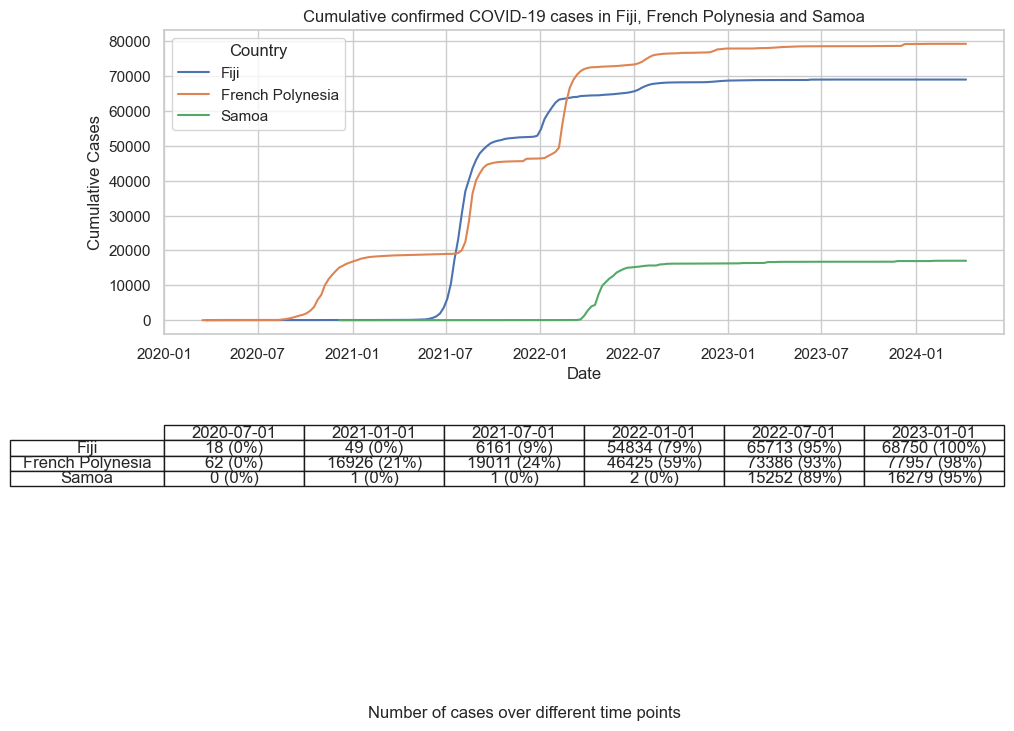

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设你的数据已经加载到 fj_real, pf_real 和 ws_real
# 合并数据集
combined_data = pd.concat([fj_real, pf_real, ws_real], ignore_index=True)

# 转换为长格式
combined_data['Date_reported'] = pd.to_datetime(combined_data['Date_reported'])
combined_data.sort_values('Date_reported', inplace=True)

# 获取每个国家在每个时间点上的累积病例数并将其转换为整数
risk_data = combined_data.pivot_table(values='Cumulative_cases', 
                                      index='Date_reported', 
                                      columns='Country', 
                                      aggfunc='max').fillna(0).reset_index()

# 将浮点数转换为整数
risk_data = risk_data.astype({country: 'int' for country in risk_data.columns if country != 'Date_reported'})

# 确保数据是正确的
print(risk_data.head())

# 选择与y轴主要刻度线（Major Ticks）对齐的日期点
# 这里，我们假设你希望表格中的时间点与实际日期对应
selected_dates = pd.to_datetime([
    '2020-07-01',  # 起始日期
    '2021-01-01',  # 选择一些关键日期
    '2021-07-01',
    '2022-01-01',
    '2022-07-01',
    '2023-01-01'
])

# 找到每个日期点的数据
risk_table = []
for country in risk_data.columns[1:]:
    country_data = []
    for date in selected_dates:
        nearest_date = risk_data['Date_reported'].loc[(risk_data['Date_reported'] - date).abs().idxmin()]
        cases = risk_data[risk_data['Date_reported'] == nearest_date][country].values[0]
        country_data.append(f"{cases} ({cases / risk_data[country].max() * 100:.0f}%)")
    risk_table.append(country_data)

# 设置列标签
columns = selected_dates.strftime('%Y-%m-%d').tolist()

# 打印生成的表格数据
for row in risk_table:
    print(row)

# 绘制累积曲线图
fig, ax = plt.subplots(figsize=(12, 8))

# 设置图表风格
sns.set(style="whitegrid")

# 绘制累积曲线图
sns.lineplot(data=combined_data, x='Date_reported', y='Cumulative_cases', hue='Country', hue_order=risk_data.columns[1:], errorbar=None, ax=ax)

# 添加图表标题和标签
ax.set_title('Cumulative confirmed COVID-19 cases in Fiji, French Polynesia and Samoa')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Cases')
ax.legend(title='Country')

# 添加“Number at risk”表格
table = plt.table(cellText=risk_table,
                  rowLabels=risk_data.columns[1:],
                  colLabels=columns,
                  cellLoc='center',
                  rowLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.2])  # 调整表格的位置和大小

# 调整图表底部的边距，使表格与图表的尺度对齐
plt.subplots_adjust(left=0.2, bottom=0.5)

# 添加下标题
plt.figtext(0.5, 0.02, 'Number of cases over different time points', ha='center', fontsize=12)

# 保存和显示图表
plt.savefig('cumulative_cases.png', bbox_inches='tight', dpi=300)
plt.show()

/var/folders/6b/kz_zdjy5609583gv1q69hvcm0000gn/T/ipykernel_55111/1179348676.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  combined_data['Date_reported'] = pd.to_datetime(combined_data['Date_reported'])


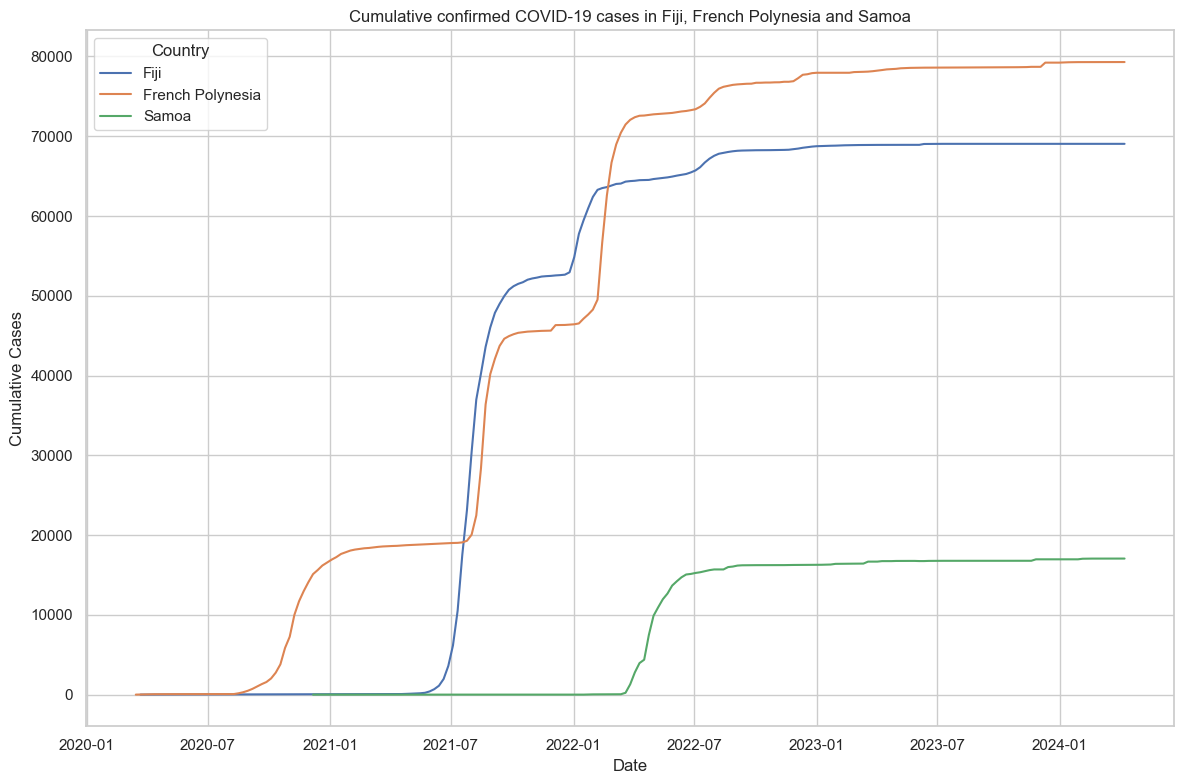

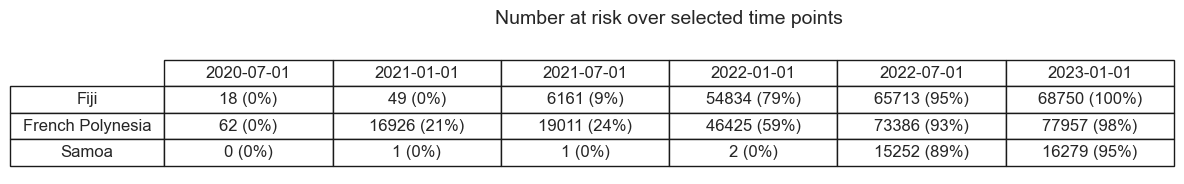

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设数据已加载完毕并处理
combined_data = pd.concat([fj_real, pf_real, ws_real], ignore_index=True)
combined_data['Date_reported'] = pd.to_datetime(combined_data['Date_reported'])
combined_data.sort_values('Date_reported', inplace=True)

# 累积病例数据
risk_data = combined_data.pivot_table(
    values='Cumulative_cases',
    index='Date_reported',
    columns='Country',
    aggfunc='max'
).fillna(0).reset_index()

# 转换为整数
risk_data = risk_data.astype({col: 'int' for col in risk_data.columns if col != 'Date_reported'})

# 日期选择
selected_dates = pd.to_datetime([
    '2020-07-01',
    '2021-01-01',
    '2021-07-01',
    '2022-01-01',
    '2022-07-01',
    '2023-01-01'
])

# 构建“Number at risk”表格数据
risk_table = []
for country in risk_data.columns[1:]:
    row = []
    for date in selected_dates:
        nearest_date = risk_data['Date_reported'].loc[(risk_data['Date_reported'] - date).abs().idxmin()]
        value = risk_data[risk_data['Date_reported'] == nearest_date][country].values[0]
        row.append(f"{value} ({value / risk_data[country].max() * 100:.0f}%)")
    risk_table.append(row)

columns = selected_dates.strftime('%Y-%m-%d').tolist()

# ============ 图1: 累积曲线图 ============
fig1, ax1 = plt.subplots(figsize=(12, 8))
sns.set(style="whitegrid")
sns.lineplot(
    data=combined_data,
    x='Date_reported',
    y='Cumulative_cases',
    hue='Country',
    hue_order=risk_data.columns[1:],
    errorbar=None,
    ax=ax1
)
ax1.set_title('Cumulative confirmed COVID-19 cases in Fiji, French Polynesia and Samoa')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Cases')
ax1.legend(title='Country')
plt.tight_layout()
plt.savefig('cumulative_curve.png', dpi=300)
plt.show()

# ============ 图2: 风险表格 ============
fig2, ax2 = plt.subplots(figsize=(12, 2))
ax2.axis('off')  # 关闭坐标轴
table = plt.table(
    cellText=risk_table,
    rowLabels=risk_data.columns[1:],
    colLabels=columns,
    cellLoc='center',
    rowLoc='center',
    loc='center'
)
table.scale(1, 2)  # 可调整行高
plt.title('Number at risk over selected time points', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('number_at_risk_table.png', dpi=300)
plt.show()